In [10]:
from ema import read

%load_ext autoreload
%autoreload 2


In [2]:
meal_info = read.all_meal_info()

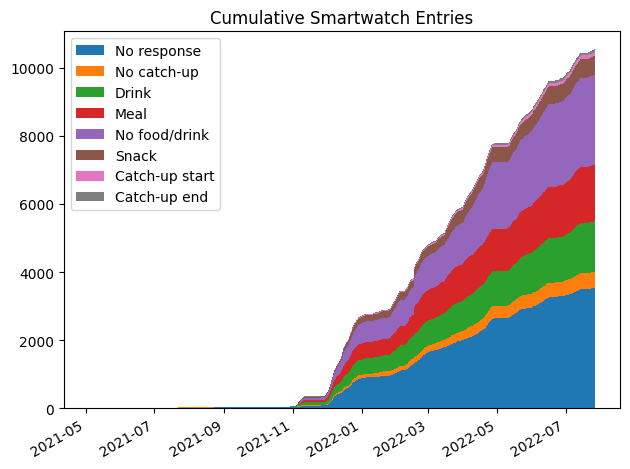

In [3]:
"""
Plot a cumulative histogram showing the number of each type of meal

"""
import pandas as pd
import matplotlib.pyplot as plt

min_time, max_time = meal_info.index.min(), meal_info.index.max()

fig, axis = plt.subplots()
bins = pd.date_range(min_time, max_time, freq="1H")

labels = meal_info["meal_type"].unique()
data = [meal_info[meal_info["meal_type"] == meal_type].index for meal_type in labels]
axis.hist(data, bins=bins, stacked=True, label=labels, cumulative=True)

axis.legend()
axis.set_title("Cumulative Smartwatch Entries")

fig.autofmt_xdate()
fig.tight_layout()
fig.savefig("img/smartwatch_entries.png")

In [4]:
import numpy as np

# Find each unique user
p_ids = meal_info["p_id"].unique()

# Find the first date for each participant
first_dates = []
for p_id in p_ids:
    dates = pd.unique(meal_info[meal_info["p_id"] == p_id]["firstdate"])
    assert len(dates) == 1, f"Multiple first dates for participant {p_id}"

    first_dates.append(pd.to_datetime(dates[0], format=r"%d %b %y"))

first_dates = pd.Series(first_dates)

# build up a matrix of participant ids and non-response rate
non_response_matrix = np.ones((len(p_ids), 8)) * np.nan
response_matrix = np.ones((len(p_ids), 8)) * np.nan

# For each participant, find the non-response rate for each of the eight days following their first recording
for p_id, start_date, non_response_row, response_row in zip(
    p_ids, first_dates, non_response_matrix, response_matrix
):
    # Slice the dataframe to find the meals recorded by this participant
    this_participant = meal_info[meal_info["p_id"] == p_id]

    # Find the non-response rate for each day
    for i in range(8):
        date = start_date + pd.Timedelta(days=i)
        this_date = this_participant[this_participant.index.date == date.date()]

        # Find the number of "no response" entries
        negative_response = ["No response"]
        n_no_response = np.sum(this_date["meal_type"].isin(negative_response))

        non_response_row[i] = n_no_response

        # Find the number of "Drink", "Meal", "Snack", "No food/drink" entries
        positive_response = ["Drink", "Meal", "Snack", "No food/drink"]
        n_response = np.sum(this_date["meal_type"].isin(positive_response))

        response_row[i] = n_response

        # Error if there's anything else
        ignore_response = ["No catch-up", "Catch-up start", "Catch-up end"]
        assert (
            this_date["meal_type"]
            .isin(ignore_response + positive_response + negative_response)
            .values.all()
        ), "Unexpected meal type encountered"

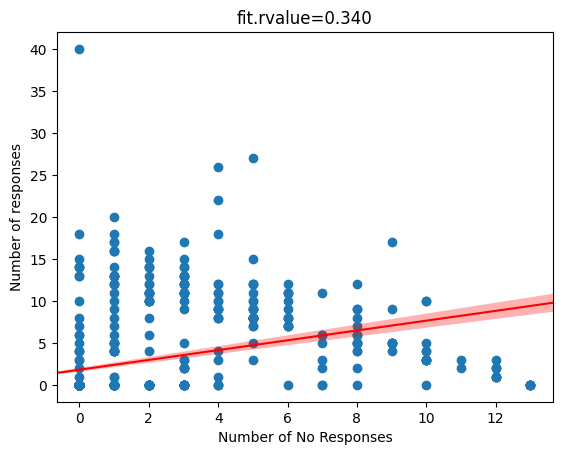

In [5]:
"""
Scatter plot of response rate vs. non-response rate for each participant on each day of the study

"""
from scipy.stats import linregress

fig, axis = plt.subplots()

axis.scatter(non_response_matrix.ravel(), response_matrix.ravel())
axis.set_xlabel("Number of No Responses")
axis.set_ylabel("Number of responses")

# Linear regression
fit = linregress(
    non_response_matrix.ravel(), response_matrix.ravel(), alternative="two-sided"
)
fit_x = axis.get_xlim()
axis.plot(fit_x, [fit.intercept + fit.slope * x for x in fit_x], color="red")
axis.fill_between(
    fit_x,
    [
        fit.intercept - fit.intercept_stderr + (fit.slope - fit.stderr) * x
        for x in fit_x
    ],
    [
        fit.intercept + fit.intercept_stderr + (fit.slope + fit.stderr) * x
        for x in fit_x
    ],
    color="red",
    alpha=0.3,
    edgecolor=None,
)
axis.set_xlim(fit_x)

axis.set_title(f"{fit.rvalue=:.3f}")

fig.savefig("img/response_scatter.svg")

100%|██████████| 8/8 [00:00<00:00, 39.06it/s]


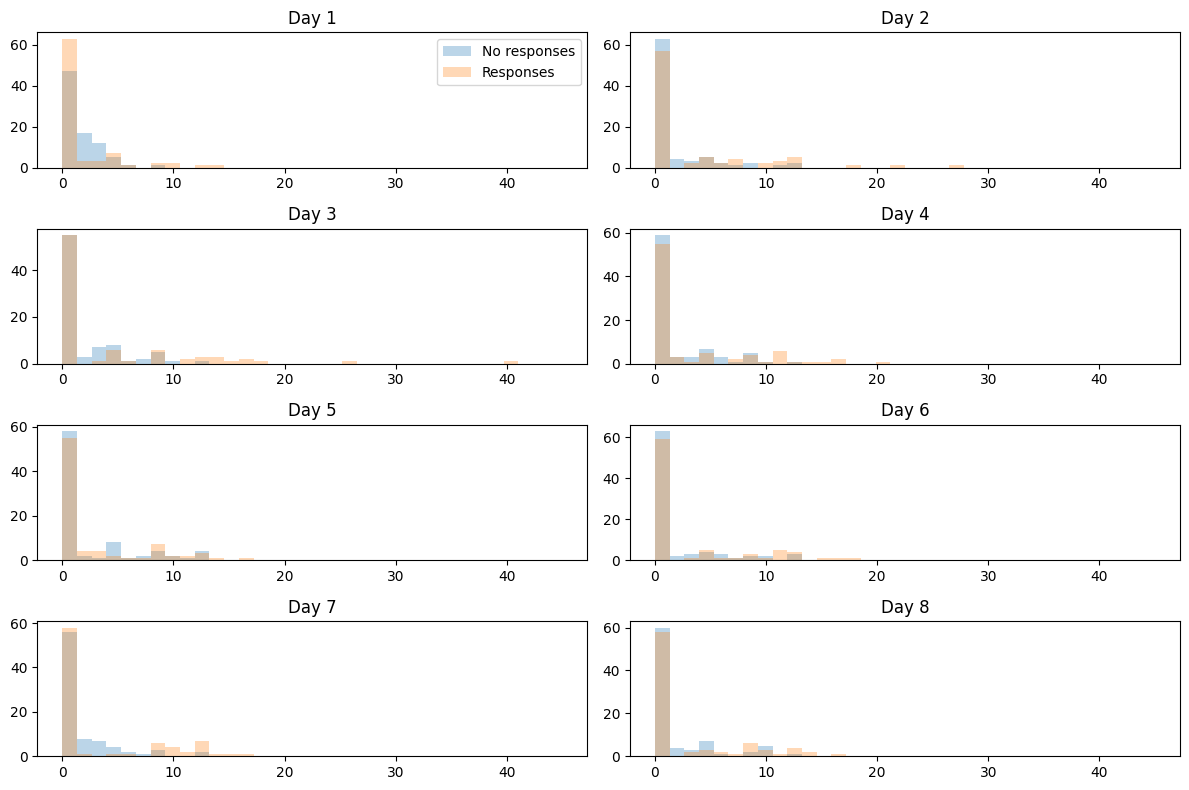

In [6]:
"""
Plot histograms of the number of responses and non-responses on each day of the trial

"""
from tqdm import tqdm

fig, axes = plt.subplots(4, 2, figsize=(12, 8))

bins = np.linspace(0, 45, 35)
hist_kw = {"bins": bins, "alpha": 0.3}
for day, axis in tqdm(zip(range(8), axes.ravel()), total=8):
    axis.set_title(f"Day {day + 1}")
    axis.hist(non_response_matrix[:, day], label="No responses", **hist_kw)
    axis.hist(response_matrix[:, day], label="Responses", **hist_kw)

axes[0, 0].legend()

fig.tight_layout()

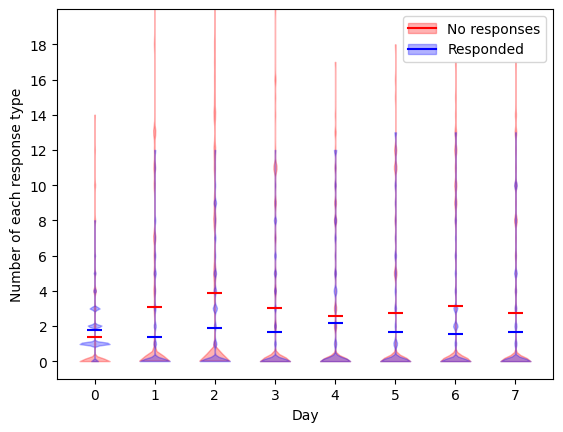

In [7]:
"""
On an axis, plot the distributions of responses and non-responses for each day of the trial

"""
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


def change_colour(violin, colour):
    """
    Change colour of violin plot; there's no easy builtin to do this

    """
    for part in violin:
        if part == "bodies":
            for body in violin["bodies"]:
                body.set_color(colour)
            continue

        violin[part].set_color(colour)


def add_label(axis, violins, labels):
    """
    Add labels to an axis for a series of violin plots

    """
    legend = []
    for violin, label in zip(violins, labels):
        color = violin["bodies"][0].get_facecolor().flatten()
        legend.append(
            (
                (
                    mpatches.Patch(color=color),
                    Line2D([], [], color=color[:3]),  # alpha is ignored
                ),
                label,
            )
        )
    axis.legend(*zip(*legend))


fig, axis = plt.subplots()

viol_kw = {
    "positions": np.arange(8),
    "showmeans": True,
    "showextrema": False,
    "bw_method": 0.05,
}
non_response_viol = axis.violinplot(response_matrix, **viol_kw)
response_viol = axis.violinplot(non_response_matrix, **viol_kw)

change_colour(non_response_viol, "red")
change_colour(response_viol, "blue")

add_label(axis, (non_response_viol, response_viol), ("No responses", "Responded"))

axis.set_xlabel("Day")
axis.set_ylabel("Number of each response type")

axis.set_ylim(-1, 20)
axis.set_yticks(np.arange(0, axis.get_ylim()[1], 2))

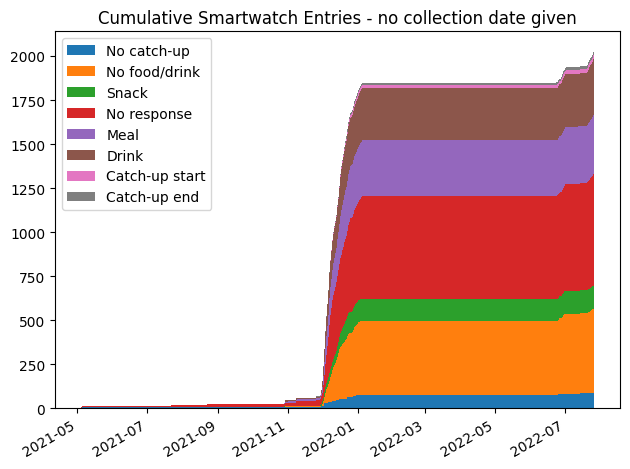

In [18]:
"""
Find the participants for whom no collection date was given; plot a histogram of their responses only

"""
no_collection_date = read.no_collection_date(meal_info["p_id"])

# Find the smartwatch entry dates for participants with no collection date
pilot_info = meal_info[meal_info["p_id"].isin(no_collection_date)]

fig, axis = plt.subplots()
bins = pd.date_range(pilot_info.index.min(), pilot_info.index.max(), freq="1H")

labels = pilot_info["meal_type"].unique()
data = [pilot_info[pilot_info["meal_type"] == meal_type].index for meal_type in labels]
axis.hist(data, bins=bins, stacked=True, label=labels, cumulative=True)

axis.legend()
axis.set_title("Cumulative Smartwatch Entries - no collection date given")

fig.autofmt_xdate()
fig.tight_layout()

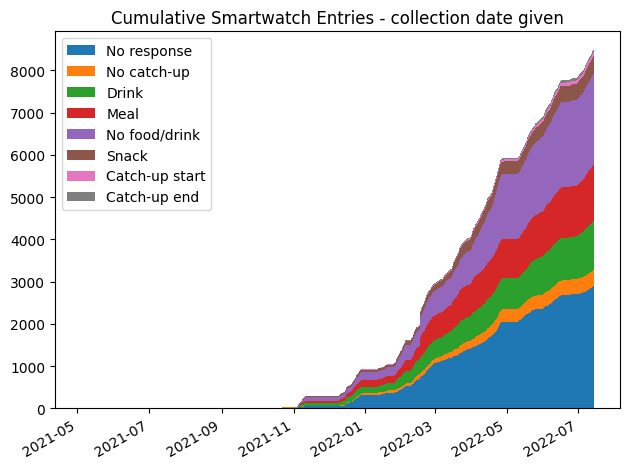

In [20]:
not_pilot_info = meal_info[~meal_info["p_id"].isin(no_collection_date)]

fig, axis = plt.subplots()
bins = pd.date_range(not_pilot_info.index.min(), not_pilot_info.index.max(), freq="1H")

labels = not_pilot_info["meal_type"].unique()
data = [not_pilot_info[not_pilot_info["meal_type"] == meal_type].index for meal_type in labels]
axis.hist(data, bins=bins, stacked=True, label=labels, cumulative=True)

axis.legend()
axis.set_title("Cumulative Smartwatch Entries - collection date given")

fig.autofmt_xdate()
fig.tight_layout()